<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/Colab_Final_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Paul Scheidt, Sean Murphy
# Description: Implement simple Machine Learning Classification Model for SAT6 Database
# Implement ART toolbox to perform poisoning attack


# Compare pixel distributions of typical classes, then compare pixel distributions of adversarial data
# Array statistics


Quality of Data and Preprocessing

In [2]:
# Required Python Libraries
from google.colab import drive
import random
import time

# Libraries for CNN
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D,MaxPool2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from PIL import Image

# Libraries for Visualizing Deeplearning Models
from IPython import display
from tensorflow.keras.utils import plot_model
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.ndimage import zoom

In [3]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [5]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

In [6]:
class_names = ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']
class_count = len(class_names)

print("Num. classes: %d" % class_count)
print("Class names:", class_names)

Num. classes: 6
Class names: ['Construction', 'Road', 'Grassland', 'Barren', 'Water', 'Treecover']


In [7]:
def label_converter(values):
  if values[0] == 1:    # Building
    return 0
  elif values[1] == 1:  # Barren land
    return 3
  elif values[2] == 1:  # Trees
    return 5
  elif values[3] == 1:  # Grassland
    return 2
  elif values[4] == 1:  # Road
    return 1
  elif values[5] == 1:  # Water
    return 4
  else:
    return None

In [8]:
y_train = y_train.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_train = train_label.values.ravel().astype('uint8')
#y_train = train_label.apply(label_converter, axis=1).astype('category')
y_train

y_test = y_test.apply(label_converter, axis=1).values.ravel().astype('uint8')
#y_test = test_label.values.ravel().astype('uint8')
#y_test = test_label.apply(label_converter, axis=1).astype('category')
y_test

array([5, 5, 4, ..., 5, 4, 5], dtype=uint8)

In [9]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 3714,  2070, 12596, 18367, 30068, 14185]))

In [10]:
x_train_partial, x_validation, y_train_partial, y_validation = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

print(x_train_partial.shape)
print(x_validation.shape)
print(y_train_partial.shape)
print(y_validation.shape)

(226800, 28, 28, 4)
(97200, 28, 28, 4)
(226800,)
(97200,)


In [11]:
def train_and_test(id, model, x_train, y_train, x_test, y_test, epochs=10):
    global best_model, best_accuracy

    start_time = datetime.now()
    model.fit(x_train, y_train, epochs=epochs,batch_size=32)

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    print("Training took %.1f seconds" % duration)

    print(f"Model eval:")
    accuracy = model.evaluate(x_test, y_test)

    return accuracy

In [12]:
def create_modelv1(class_count, print_summary=False):
# Implementing Multi-Class, Classifier CNN in Tensor Flow
# Description: Implement traditional model, highlight model architecture, train and evaluate model performance

  input = tf.keras.Input(shape=(28,28,4))
  x = layers.Conv2D(filters=32,kernel_size=4,activation='relu')(input)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x= layers.Conv2D(filters=64,kernel_size=4,activation='relu',name='final_conv_layer')(x)
  x = layers.MaxPooling2D(pool_size=(2,2))(x)
  x = layers.GlobalAveragePooling2D()(x)   # Need Global average Pooling in order to visuals CAMs
  x = layers.Dense(128,activation='relu')(x)
  output = layers.Dense(class_count,activation='softmax')(x)

  model = tf.keras.Model(inputs=input,outputs=output)


  model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  if print_summary:
    model.summary()
    # Displaying CNN Model
    plt.figure(figsize=(10, 10))
    plot_model(model, show_shapes=True, show_layer_names=True, dpi=100)
  return model

In [13]:
# Saving the best model performance for baseline model with early stopping after 5 EPOCHs.
checkpoint = [
    keras.callbacks.ModelCheckpoint(
        filepath="./baseline-model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max',
        verbose=1)
]
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max')
callbacks_list = [checkpoint,earlystop]

In [14]:
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [15]:

x_test_lim = x_test[:15000]
y_test_lim = y_test[:15000]
x_train_lim = x_train[:15000]
y_train_lim = y_train[:15000]


In [16]:
# Compiling Modelv1

modelv1 = create_modelv1(6,True)


history_baseline_modelv1 = modelv1.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test,y_test),
    callbacks=callbacks_list)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 25, 25, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_conv_layer (Conv2D)            │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,006 (171.90 KB)

 Trainable params: 44,006 (171.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9262 - loss: 0.2942
Epoch 1: val_accuracy improved from -inf to 0.96031, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9262 - loss: 0.2941 - val_accuracy: 0.9603 - val_loss: 0.1006
Epoch 2/10
5055/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9656 - loss: 0.0937
Epoch 2: val_accuracy improved from 0.96031 to 0.97011, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9656 - loss: 0.0937 - val_accuracy: 0.9701 - val_loss: 0.0916
Epoch 3/10
5056/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.0789
Epoch 3: val_accuracy improved from 0.97011 to 0.98263, saving model to ./baseline-model.keras
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9718 - loss: 0.0789 - val_accuracy: 0.9826 - val_loss: 0.0514
Epoch 4/10
5054/5063 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9765 - loss: 0.0662
Epoch 

<Figure size 1000x1000 with 0 Axes>

In [17]:
def fgsm_attack(model, images, labels, epsilon):
    # Enable gradient tape for automatic differentiation
    with tf.GradientTape() as tape:
        # Cast images to float32 if they are not already
        # Set Batch Size


        images = tf.convert_to_tensor(images, dtype=tf.float32)

        # Make the model predictions
        tape.watch(images)
        predictions = model(images, training=True)
        # print(predictions)
        # Calculate the loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)
        print(loss)

    # Calculate gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, images)

    if gradients is None:
        raise ValueError('NO GRAD')
    # print(gradients)
    # Get the sign of the gradients
    signed_gradients = tf.sign(gradients)
    # Create the adversarial images
    adversarial_images = images + epsilon * signed_gradients
    # Clip the values to maintain valid pixel range
    # adversarial_images = tf.clip_by_value(adversarial_images, 0, 1)  # Adjust based on normalization

    return adversarial_images

In [50]:
epsilon=[0.01,0.02,0.04,0.06,0.08,1.0,1.5,2,2.5,3,3.5,4,5,6,8,10,12,15,17,20,22,25,30]
loss_log = []
accuracy_log = []
for i in epsilon:
  adversarial_images = fgsm_attack(modelv1, x_test_lim, y_test_lim, i)
  loss,accuracy = modelv1.evaluate(adversarial_images, y_test_lim)
  loss_log.append(loss)
  accuracy_log.append(accuracy)


tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0372
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9874 - loss: 0.0382
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9866 - loss: 0.0401
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9858 - loss: 0.0420
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9854 - loss: 0.0440
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9463 - loss: 0.1714
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9232 - loss: 0.2618
tf.Tensor(0.038347684, shape=(), dtype=float32)
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9015 - loss: 0.3578
tf.Tensor(0.0383

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


Text(0.5, 1.0, 'Epsilon 30')

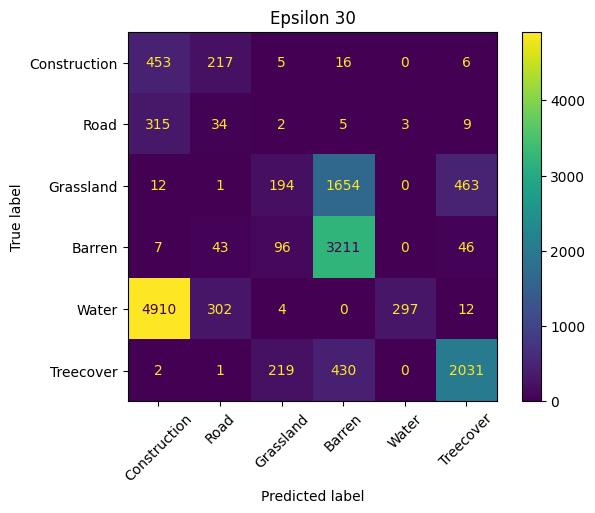

In [67]:
# Confusion Matrix highlighting Model Classification Perfromance pre-Poison Attack
# Load the best perfroming Model
conf_model = load_model('./baseline-model.keras')
# Obtain prediction labels from model
y_pred = conf_model.predict(adversarial_images)

# Create Confusion Matrix based off predictions
ConfusionMatrixDisplay.from_predictions(y_true=y_test_lim, y_pred=y_pred.argmax(axis=1), display_labels=class_names,xticks_rotation=45)
plt.title("Epsilon 30")

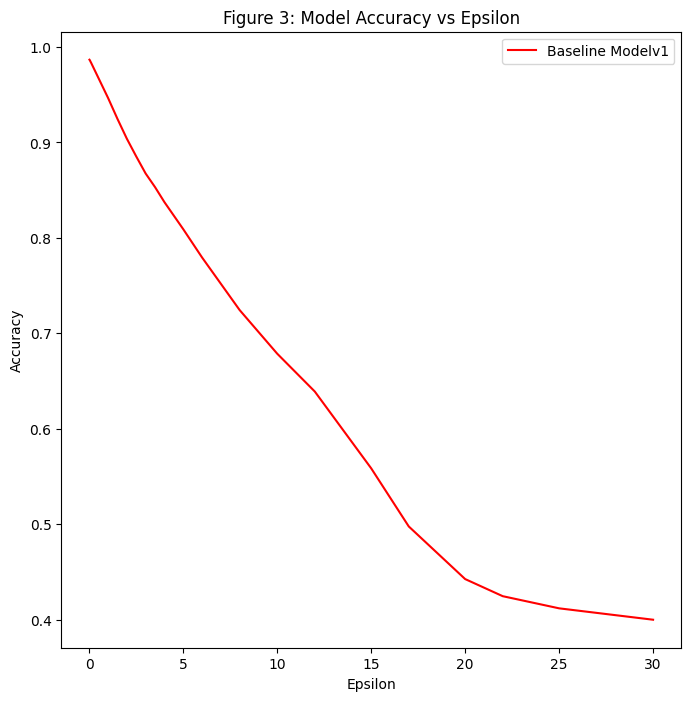

In [52]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(epsilon,accuracy_log,'r',label='Baseline Modelv1')
plt.title('Figure 3: Model Accuracy vs Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend()
plt.show()



In [20]:
images = []
for tens in adversarial_images:
    images.append(tens.numpy())

In [21]:
adverse_numpy = adversarial_images.numpy()
adverse_numpy_viz = np.clip(adverse_numpy, 0, 255) / 255

In [22]:
adverse_mean, adverse_std = np.mean(adverse_numpy, axis=(0,1,2)), np.std(adverse_numpy, axis=(0,1,2))

In [23]:
clean_mean, clean_std = np.mean(x_test_lim, axis=(0,1,2)), np.std(x_test_lim, axis=(0,1,2))

In [24]:
print(f"Adversarial Mean: {adverse_mean}")
print(f"Adversarial Std: {adverse_std}")
print(f"Clean Mean: {clean_mean}")
print(f"Clean Std: {clean_std}")

Adversarial Mean: [112.29613 114.53824 115.80239 104.46968]
Adversarial Std: [54.082153 47.317833 36.81291  75.856476]
Clean Mean: [112.69007347 114.99072832 114.39533886 107.69923376]
Clean Std: [54.61908614 47.78322136 37.09629127 76.57921746]


In [25]:
# t-test red channel (example for other channels, [:,:,:, n for R G B NIR])
from scipy import stats

adverse_red = adverse_numpy[:,:,:,0].flatten()
clean_red = x_test_lim[:,:,:,0].flatten()

t_test, p_value_tt = stats.ttest_ind(adverse_red, clean_red)

In [26]:
print(t_test,p_value_tt)

2.870435835565622 0.004099067446698716


In [27]:
# anova
f_stat, p_value_anova = stats.f_oneway(adverse_red, clean_red)
print(f_stat, p_value_anova)

8.242380510642056 0.004092346161369151


In [28]:
redDf = pd.DataFrame({
    'red': np.concatenate([adverse_red, clean_red]),
    'poison': ['adversarial'] * len(adverse_red) + ['clean'] * len(clean_red),
})

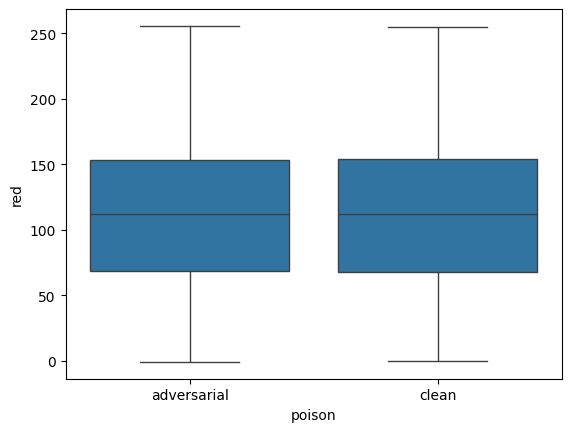

In [56]:
sns.boxplot(x='poison', y='red', data=redDf)
plt.show()

(-0.5, 27.5, 27.5, -0.5)

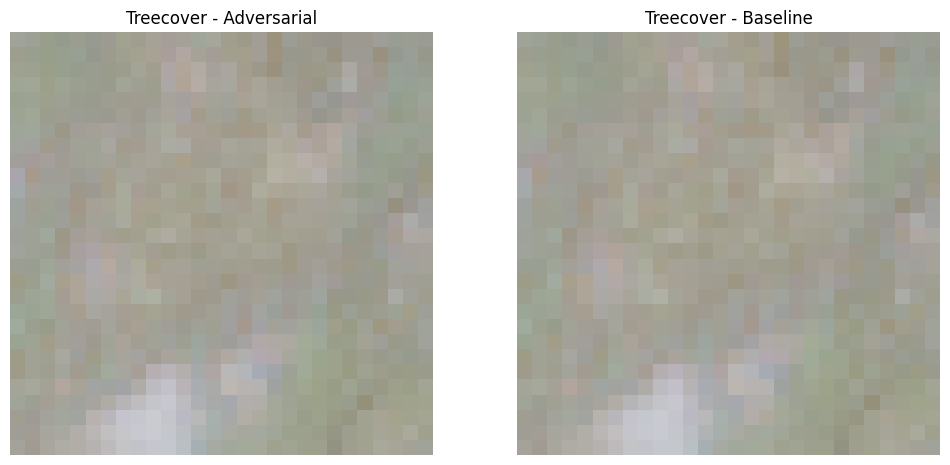

In [55]:
# side-by-side

fig, axs = plt.subplots(1,2, figsize=(12,6))

# adverse
axs[0].imshow(adverse_numpy_viz[128])
axs[0].set_title(class_names[y_test_lim[128]] + " - Adversarial")
axs[0].axis('off')

# clean
axs[1].imshow(x_test_lim[128])
axs[1].set_title(class_names[y_test_lim[128]] + " - Baseline")
axs[1].axis('off')

Text(0.5, 1.0, 'Water')

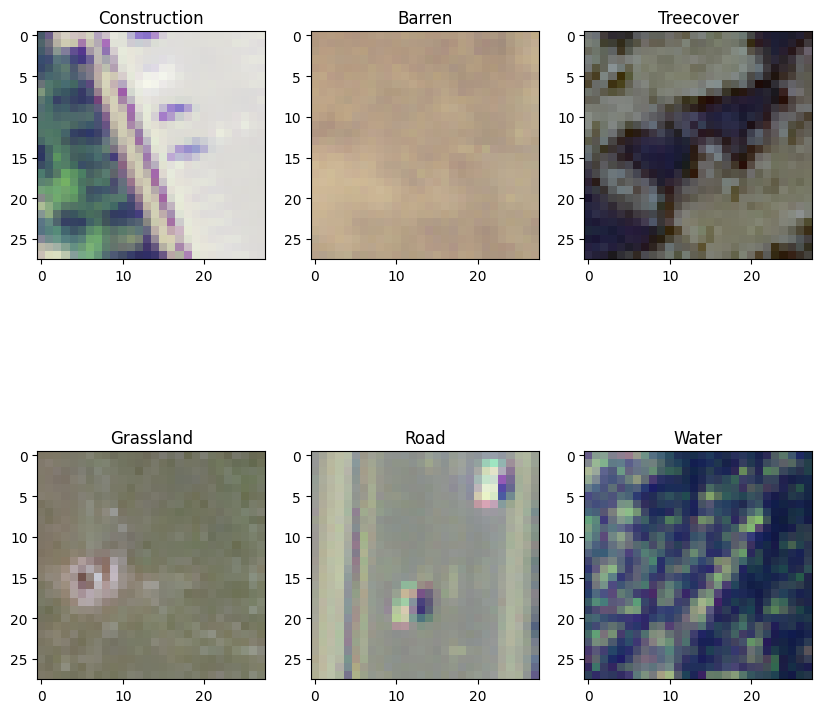

In [31]:
# This Code Block Highlights examples of images from each class


fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = class_names[y_train[6]]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = class_names[y_train[1]]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = class_names[y_train[0]]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = class_names[y_train[17]]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = class_names[y_train[13]]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = class_names[y_train[3]]
plt.imshow(img_F)
ax6.set_title(label_F)

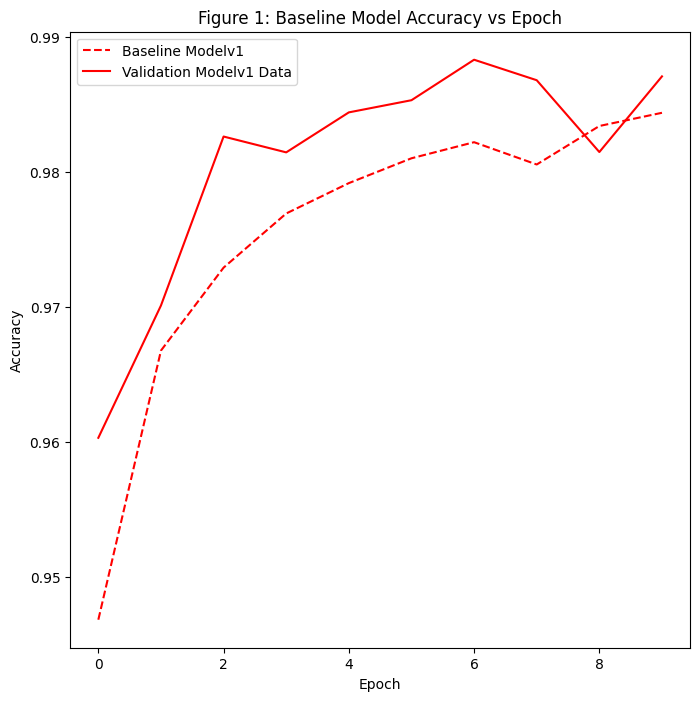

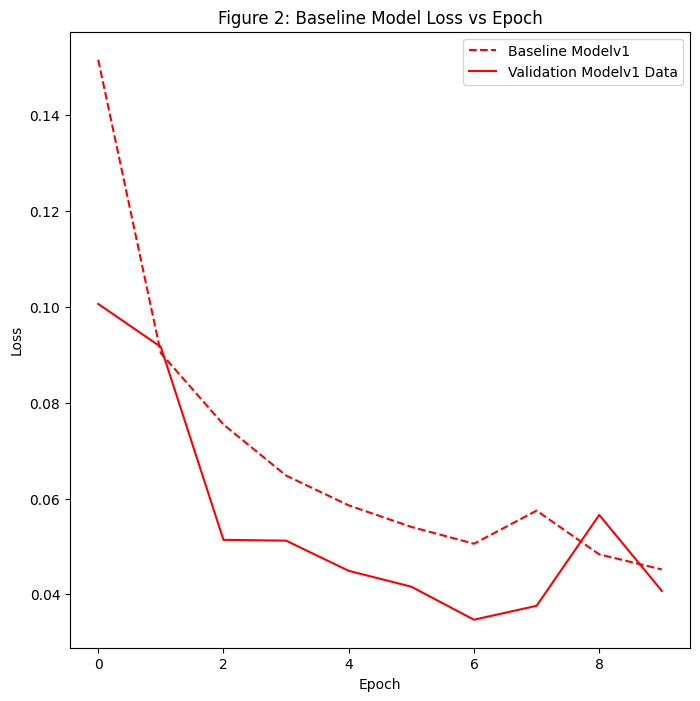

In [32]:
accuracy = plt.figure(figsize =(8, 8))

plt.plot(history_baseline_modelv1.history['accuracy'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_accuracy'],'r',label='Validation Modelv1 Data')
plt.title('Figure 1: Baseline Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss = plt.figure(figsize =(8, 8))
plt.plot(history_baseline_modelv1.history['loss'],'r--',label='Baseline Modelv1')
plt.plot(history_baseline_modelv1.history['val_loss'],'r',label='Validation Modelv1 Data')
plt.title('Figure 2: Baseline Model Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [33]:
# Grad-CAM heatmap Visualization
# Grad-CAM visualizations help verify what areas in an image a model is using to
# determine a class. This visual works by finding the final convolutional layer
# in the network and then investigating the output of the weights prior to global
# pooling.

model_a = load_model('./baseline-model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


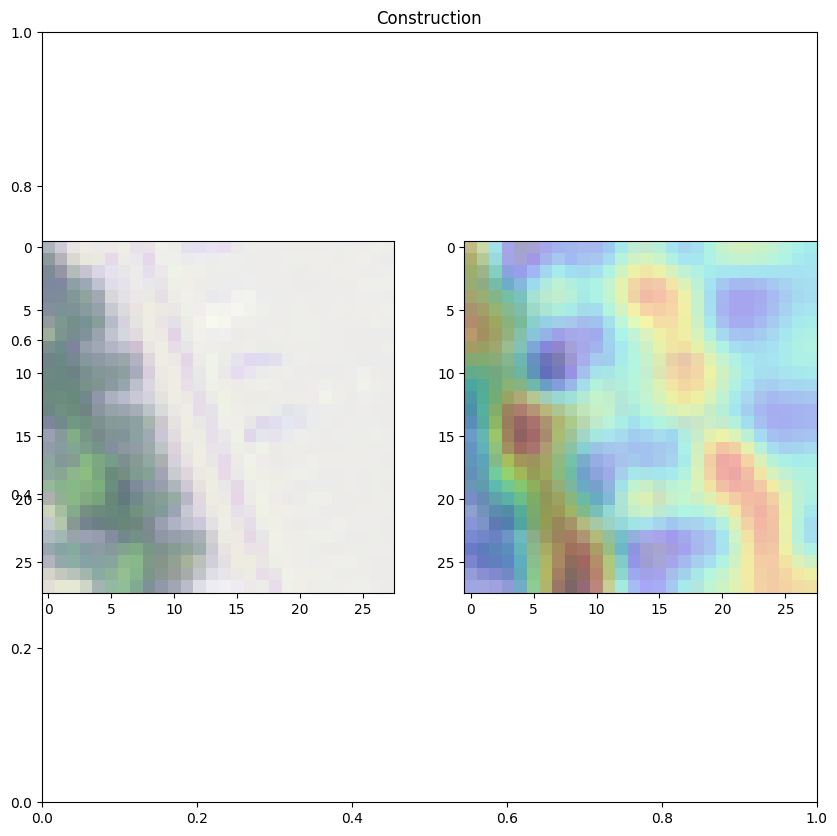

In [34]:
# Setting up a model that returns the last convolutional output

conv_layer_name = "final_conv_layer"
conv_output = model_a.get_layer(conv_layer_name).output
pred_output = model_a.get_layer("dense").output

CAM_model_a = Model(inputs=model_a.input, outputs=(conv_output, pred_output))

conv, pred = CAM_model_a.predict(x_train[6].reshape([1,28,28,4]))

# Reference: https://tree.rocks/get-heatmap-from-cnn-convolution-neural-network-aka-grad-cam-222e08f57a34




target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2

plt.title(class_names[y_train[6]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[6])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


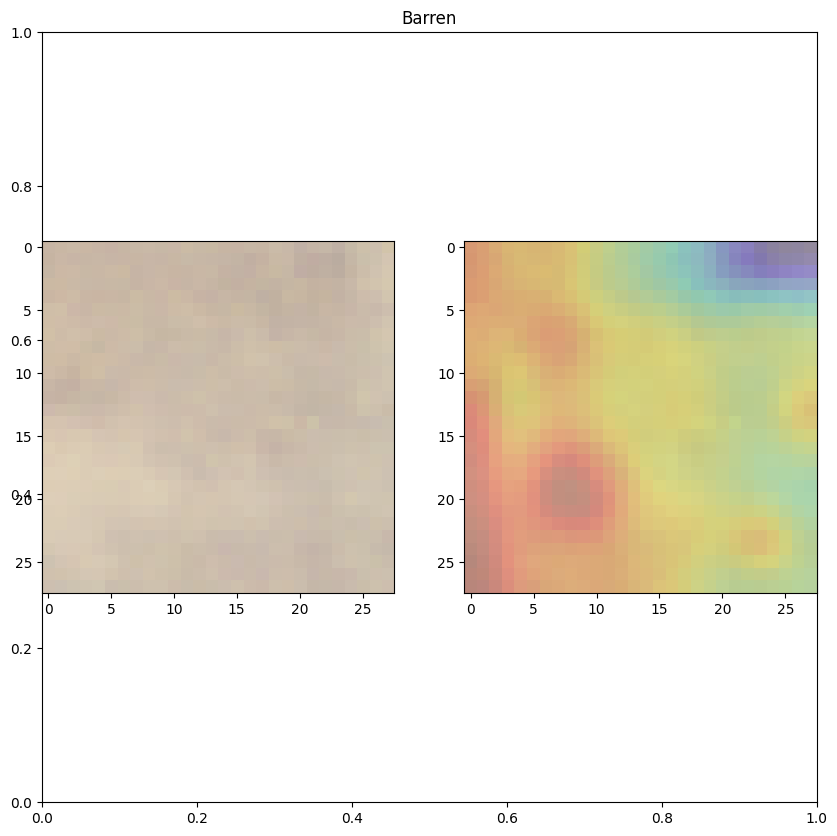

In [35]:
conv, pred = CAM_model_a.predict(x_train[1].reshape([1,28,28,4]))



target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2

plt.title(class_names[y_train[1]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[1])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


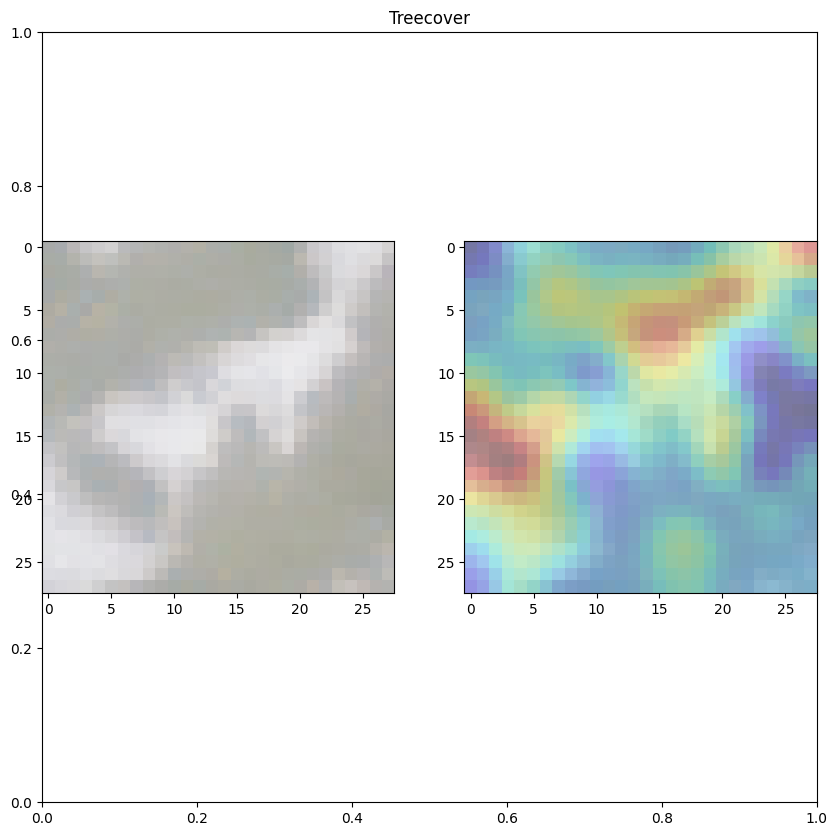

In [36]:
conv, pred = CAM_model_a.predict(x_train[0].reshape([1,28,28,4]))



target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2

plt.title(class_names[y_train[0]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[0])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


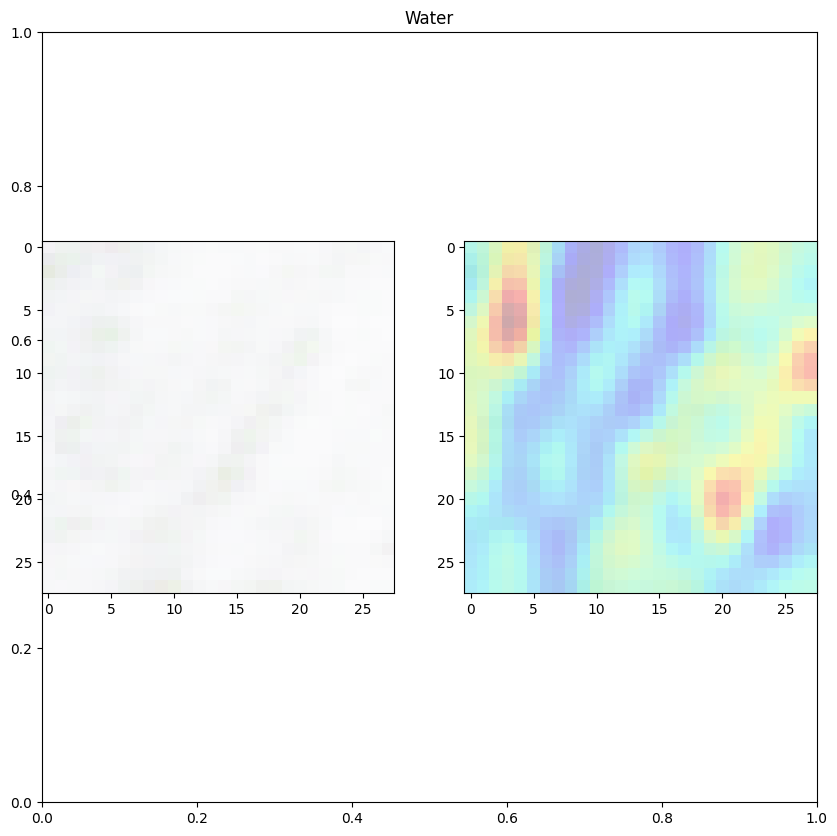

In [37]:
conv, pred = CAM_model_a.predict(x_train[3].reshape([1,28,28,4]))



target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2

plt.title(class_names[y_train[3]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[3])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


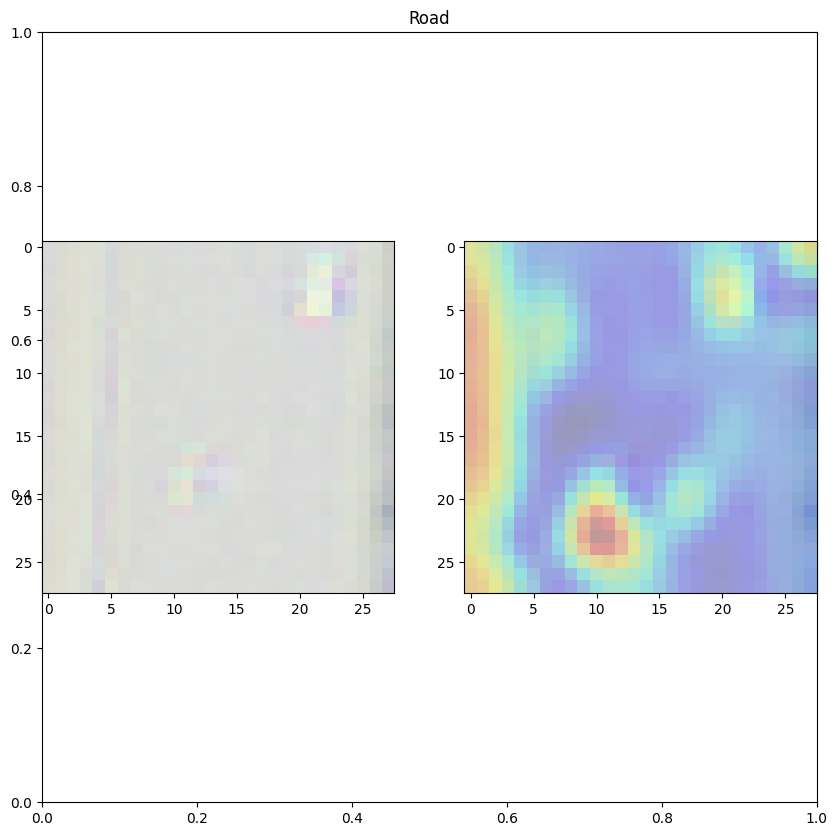

In [38]:
conv, pred = CAM_model_a.predict(x_train[13].reshape([1,28,28,4]))



target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2


plt.title(class_names[y_train[13]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[13])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


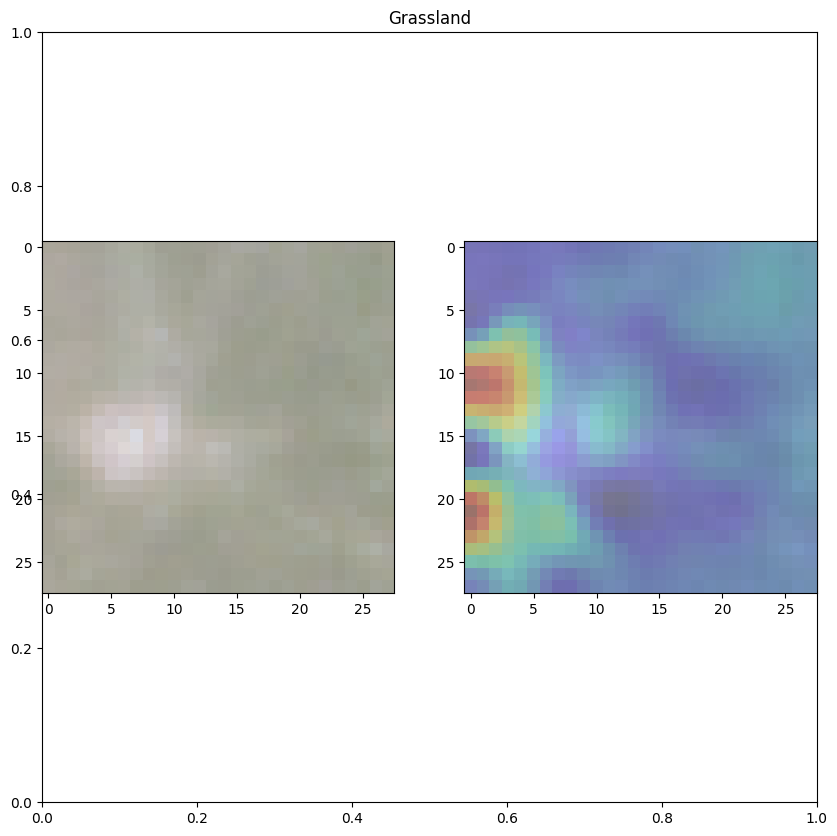

In [39]:
conv, pred = CAM_model_a.predict(x_train[17].reshape([1,28,28,4]))



target = np.argmax(pred, axis=1).squeeze()
w, b = CAM_model_a.get_layer("dense").weights
weights = w[:, target].numpy()

heatmap = conv.squeeze().dot(weights)

fig = plt.figure(figsize = (10,10))
rows = 1
cols = 2

plt.title(class_names[y_train[17]])
ax1 = fig.add_subplot(rows, cols, 1)
image_array = Image.fromarray(x_train[17])
plt.imshow(image_array)

ax2 = fig.add_subplot(rows, cols, 2)
plt.imshow(image_array)
plt.imshow(zoom(heatmap, zoom=(28/9, 28/9)), cmap='jet', alpha=0.3)

2532/2532 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


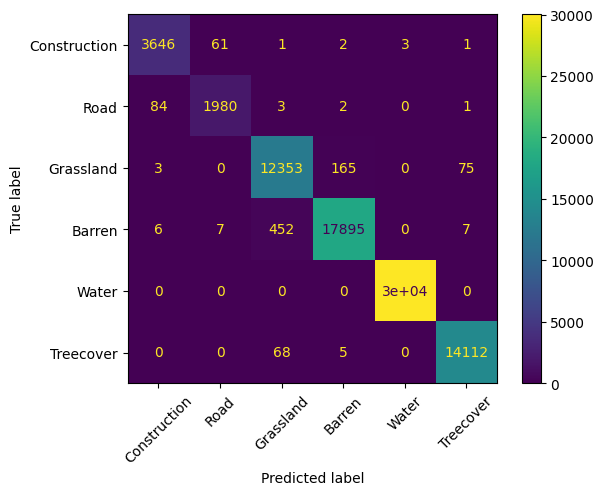

In [40]:
# Confusion Matrix highlighting Model Classification Perfromance pre-Poison Attack

# Load the best perfroming Model
conf_model = load_model('./baseline-model.keras')

# Obtain prediction labels from model
y_pred = conf_model.predict(x_test)

# Create Confusion Matrix based off predictions
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred.argmax(axis=1), display_labels=class_names,xticks_rotation=45)